In [67]:
import json
import gensim
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler

## Read in Comments Data

In [54]:
with open(r'../Data/Dataset/comments.json') as f:
    comments = json.load(f)

In [58]:
df = pd.DataFrame(comments)[['comment', 'label']]
df = df[(df['label'] == 1) | (df['label'] == 2)]
df.head()

,comment,label
5,Lol,2
18,With Rosen still on the board I gotta think th...,2
21,mistake,2
22,I think its a great pick at 7,1
23,I am; mistake lol,2


In [59]:
comments = df.to_numpy()

To get all comment text:

In [60]:
comments[:, 0]

array(['Lol',
       'With Rosen still on the board I gotta think this is a mistake',
       'mistake', ...,
       "Williams helped his stats so much. Not a fan at all. He's clutch and good in the pocket but that championship game made him a value he never deserved imho.",
       'Rip Watson ', 'Sorry JJ Watt, no playoffs for you.'], dtype=object)

To get all labels:

In [61]:
comments[:, 1]

array([2, 2, 2, ..., 2, 2, 2], dtype=object)

Total dataset size:

In [62]:
len(comments)

4268

## Create Model Objects

In [63]:
docs = list(comments[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [93]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=20, min_count=2, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [94]:
doc_vectors = []
for i in range(0, len(tagged_data)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

## Visualize

In [95]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [97]:
pca = PCA(n_components=2)
pca.fit(doc_scaled)

plot_points = pca.transform(doc_scaled)

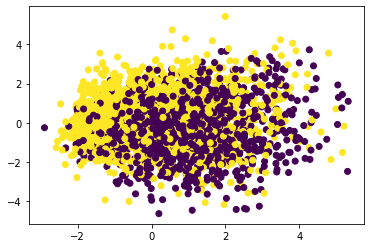

In [98]:
plt.scatter(plot_points[:, 0], plot_points[:, 1], c = comments[:, 1])

## Classify

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [117]:
X = doc_scaled
y = np.array(comments[:, 1], dtype = int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

**Logistic Regression**

In [123]:
log = LogisticRegression()
log.fit(X_train, y_train)
pred = log.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[187 116]
 [ 62 489]]
0.7915690866510539


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Naive Bayes**

In [122]:
from sklearn.naive_bayes import GaussianNB

In [124]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[193 110]
 [131 420]]
0.7177985948477752


**Support Vector Machine**

In [125]:
from sklearn.svm import SVC

In [128]:
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[215  88]
 [ 80 471]]
0.8032786885245902
